In [1]:
import os 
import re
import pandas as pd
import itertools

# Import the wordcloud library
from wordcloud import WordCloud

# EDA for LDA
import gensim
from gensim.utils import simple_preprocess

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Convert tonkenized object as a corpus and document
import gensim.corpora as corpora

from pprint import pprint

# Visualise topics
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Draculabites\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("data/allposts.csv")
df.head()

,postUrl,description,commentCount,likeCount,pubDate,likedByViewer,isSidecar,type,profileUrl,username,...,taggedFullName1,taggedUsername1,taggedFullName2,taggedUsername2,taggedFullName3,taggedUsername3,taggedFullName4,taggedUsername4,location,locationId
0,https://www.instagram.com/p/CbzXkYBsSZ0/,Happy 1st April! This means that… Our Virtual ...,0,12,2022-04-01T09:00:22.000Z,False,False,Photo,https://www.instagram.com/sgchildrensoc,sgchildrensoc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.instagram.com/p/CbhK4IQKwcd/,👀 Take a peep into #adayinthelife of a youth w...,1,36,2022-03-25T07:23:46.000Z,False,False,Video,https://www.instagram.com/sgchildrensoc,sgchildrensoc,...,GIG@JYC,jyc_at_scs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.instagram.com/p/CbeksJWrCPZ/,Singapore Children’s Society held the 1000 Ent...,0,46,2022-03-24T07:10:56.000Z,False,True,Photo,https://www.instagram.com/sgchildrensoc,sgchildrensoc,...,PARKROYAL on Beach Road,parkroyalbeachroad,Teo Chee Hean,teocheehean,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.instagram.com/p/CbeksJWrCPZ/,Singapore Children’s Society held the 1000 Ent...,0,46,2022-03-24T07:10:56.000Z,False,True,Photo,https://www.instagram.com/sgchildrensoc,sgchildrensoc,...,PARKROYAL on Beach Road,parkroyalbeachroad,Teo Chee Hean,teocheehean,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.instagram.com/p/CbeksJWrCPZ/,Singapore Children’s Society held the 1000 Ent...,0,46,2022-03-24T07:10:56.000Z,False,True,Photo,https://www.instagram.com/sgchildrensoc,sgchildrensoc,...,PARKROYAL on Beach Road,parkroyalbeachroad,Teo Chee Hean,teocheehean,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# check missing aka NO captions
df['description'].isnull().sum()

1

In [4]:
# Preprocessing on captions to make them more amenable for analysis, and reliable results. 
# RegEx to remove any punctuation, and then lowercase the text

# Remove punctuation
df['desc_processed'] = df['description'].str.replace(r'[^\w\s]', '')

# Convert to lowercase
df['desc_processed'] = df['desc_processed'].str.lower()

# Replace null values (no caption) with 'null'
df['desc_processed'].fillna('null', inplace = True)

# Print out the first rows of papers
df['desc_processed'].head()

C:\Users\Draculabites\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


0    happy 1st april this means that our virtual fl...
1     take a peep into adayinthelife of a youth wor...
2    singapore childrens society held the 1000 ente...
3    singapore childrens society held the 1000 ente...
4    singapore childrens society held the 1000 ente...
Name: desc_processed, dtype: object

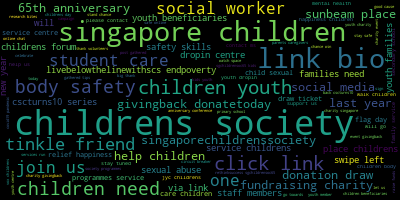

In [5]:
data = list((df['desc_processed']))

def create_cloud(data):
    text = ','.join(data)

    # Create a WordCloud object
    wordcloud = WordCloud(background_color="black", max_words=5000, contour_width=3, contour_color='steelblue')

    # Generate a word cloud
    wordcloud.generate(text)
    
    return wordcloud
    
wordcloud = create_cloud(data)
# Visualize the word cloud
wordcloud.to_image()

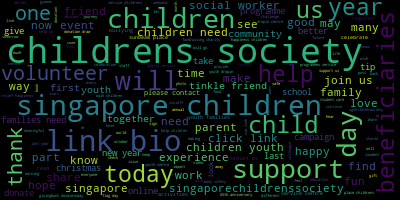

In [6]:
# Join the different distinct processed titles together.
data = list(set(df['desc_processed']))

wordcloud = create_cloud(data)
wordcloud.to_image()

In [7]:
data

['a big thank you to the playeum team and coach mike from tendencies for organising an interesting and fun activity for the residents of sunbeam place  childrens society this project is also supported by temasektrustsgs oscarsg fund\n\ntowards the end of last year our residents gathered for an exciting art of speed challenge where they worked together to build a moving vehicle with recyclable materials such as toilet rolls and unused plastic cutlery as well as motors and batteries their vehicles were then put to a test to see if they could survive moving through a track that was filled with obstacles\n\nthrough experiment and play our residents had a lot of fun learning about physics as well as discovering new things about themselves and their friends such as their strengths and weaknesses\n\nphysics handsonlearning experiment play oscarsgfund sunbeamplace sgchildrensociety',
 'what do you do when you suspect that child abuse is ongoing child abuse has been on the rise in singapore for

In [8]:
# EDA to transfrom caption into inputs for LDA 

stop_words = stopwords.words('english')
# print(len(stop_words))
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'us', 'like', 'also', 'society', 'societies', 'sgchildren', 
                   'sgchild', 'sgchildrens', 'sgchildrensoc', 'childrens', 'children', 'childs', 'child', 'singapore', 'social', 
                   'youth', 'help', 'support', 'need', 'ms', 'please', 'day', 'today', 'link', 'bio'])
# print(len(stop_words))

def to_words(sentences):
    for sentence in sentences:
        # deacc = True removes punctuations
        yield(simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word.lower() not in stop_words] for doc in texts]

data_words = list(to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words)

[['big', 'thank', 'playeum', 'team', 'coach', 'mike', 'tendencies', 'organising', 'interesting', 'fun', 'activity', 'residents', 'sunbeam', 'place', 'project', 'supported', 'temasektrustsgs', 'oscarsg', 'fund', 'towards', 'end', 'last', 'year', 'residents', 'gathered', 'exciting', 'art', 'speed', 'challenge', 'worked', 'together', 'build', 'moving', 'vehicle', 'recyclable', 'materials', 'toilet', 'rolls', 'unused', 'plastic', 'cutlery', 'well', 'motors', 'batteries', 'vehicles', 'put', 'test', 'see', 'could', 'survive', 'moving', 'track', 'filled', 'obstacles', 'experiment', 'play', 'residents', 'lot', 'fun', 'learning', 'physics', 'well', 'discovering', 'new', 'things', 'friends', 'strengths', 'weaknesses', 'physics', 'handsonlearning', 'experiment', 'play', 'oscarsgfund', 'sunbeamplace'], ['suspect', 'abuse', 'ongoing', 'abuse', 'rise', 'past', 'decade', 'members', 'community', 'play', 'crucial', 'role', 'responding', 'suspected', 'abuse', 'safeguard', 'however', 'decision', 'act', '

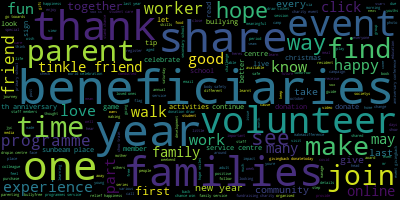

In [9]:
processed = list(itertools.chain(*data_words))

wordcloud = create_cloud(processed)
wordcloud.to_image()

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 3), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 2), (64, 1), (65, 1)], [(35, 1), (66, 5), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 3), (102, 1), (103, 1), (104, 1), (105, 1)], [(14, 1), (29, 1), (37, 1), (55, 1),

In [11]:
# LDA model training
# build a model with 5 topics 
# where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic

# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus = corpus,
                                       id2word = id2word,
                                       num_topics = num_topics)
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.006*"year" + 0.006*"one" + 0.006*"new" + 0.005*"covid" + '
  '0.005*"beneficiaries" + 0.004*"centre" + 0.004*"find" + 0.004*"service" + '
  '0.004*"family" + 0.004*"friends"'),
 (1,
  '0.005*"part" + 0.005*"school" + 0.004*"th" + 0.004*"event" + 0.004*"care" + '
  '0.004*"students" + 0.004*"beneficiaries" + 0.004*"join" + 0.004*"time" + '
  '0.003*"volunteers"'),
 (2,
  '0.005*"christmas" + 0.005*"donation" + 0.005*"beneficiaries" + '
  '0.004*"event" + 0.004*"make" + 0.004*"click" + 0.004*"vox" + 0.004*"thank" '
  '+ 0.004*"centre" + 0.003*"charity"'),
 (3,
  '0.008*"year" + 0.006*"event" + 0.006*"walk" + 0.005*"th" + 0.004*"register" '
  '+ 0.004*"charity" + 0.004*"last" + 0.004*"beneficiaries" + '
  '0.004*"anniversary" + 0.003*"school"'),
 (4,
  '0.006*"family" + 0.005*"centre" + 0.005*"families" + 0.005*"beneficiaries" '
  '+ 0.005*"programmes" + 0.004*"work" + 0.004*"hope" + 0.004*"parents" + '
  '0.004*"service" + 0.004*"school"')]


In [12]:
# Analyzing LDA model results
# Visualise for interpretability

# Better understanding and interpreting individual topics
    # manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.
# Better understanding the relationships between the topics.
    # Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/topic_modelling_caption/ldavis_prepared_'+ str(num_topics))

if True:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './results/topic_modelling_caption/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

C:\Users\Draculabites\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.005449 -0.024964       1        1  25.123788
3      0.014657  0.030397       2        1  21.338772
2     -0.059468 -0.007100       3        1  19.289246
0      0.030665 -0.033968       4        1  19.046702
1      0.008697  0.035636       5        1  15.201491, topic_info=           Term       Freq       Total Category  logprob  loglift
738   christmas  42.000000   42.000000  Default  30.0000  30.0000
342        walk  58.000000   58.000000  Default  29.0000  29.0000
1094       choo  26.000000   26.000000  Default  28.0000  28.0000
639          th  60.000000   60.000000  Default  27.0000  27.0000
672    students  35.000000   35.000000  Default  26.0000  26.0000
...         ...        ...         ...      ...      ...      ...
65         year  12.335259  112.722808   Topic5  -5.7072  -0.3287
373        make  10.114475   70.248458   Topic5  -5.9057  -0.0543
33        place   8.951735   49.773424   Topic5  -6.0278   0.1681
538     parents   9.826201   71.745941   Topic5  -5.9346  -0.1043
255       happy   9.022114   58.013181   Topic5  -6.0200   0.0228

[419 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.158574  activity
0         2  0.158574  activity
0         4  0.158574  activity
0         5  0.634294  activity
3668      4  0.822117      adam
...     ...       ...       ...
416       1  0.528249    yishun
416       2  0.162538    yishun
416       3  0.121904    yishun
416       4  0.121904    yishun
416       5  0.081269    yishun

[907 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 1, 2])